<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/OB_4%EC%A1%B0_Mini_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# < 월간 데이콘 소설 작가 분류 AI 경진대회 >

### - 링크: https://dacon.io/competitions/official/235670/overview/description

### - 목적: 문체 분석 알고리즘 개발


# 1. 라이브러리 및 데이터

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', None)
color = sns.color_palette()

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus.reader import WordNetICCorpusReader
from nltk.tokenize import word_tokenize

import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack

from xgboost import plot_importance
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_x.csv')

In [ ]:
train.head(5)

,index,text,author
0,0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and was in evident perplexity.",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by Mr. odin, she saw on looking up that odin was meeting her. Putting away the letter immediately and forcing a smile, she said:",1
3,3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the north side, if you please; Jim, the east; Gray, west. The watch below, all hands to load muskets. Lively, men, and careful.”",4
4,4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds in both halves.... Oh, my God!”",3


In [ ]:
test.head(5)

,index,text
0,0,"“Not at all. I think she is one of the most charming young ladies I ever met, and might have been most useful in such work as we have been doing. She had a decided genius that way: witness the way in which she preserved that Agra plan from all the other papers of her father. But love is an emotional thing, and whatever is emotional is opposed to that true cold reason which I place above all things. I should never marry myself, lest I bias my judgment.”"
1,1,"""No,"" replied he, with sudden consciousness, ""not to find it in YOU; for I cannot be ignorant that to you, to your goodness, I owe it all.--I feel it--I would express it if I could--but, as you well know, I am no orator."""
2,2,"As the lady had stated her intention of screaming, of course she would have screamed at this additional boldness, but that the exertion was rendered unnecessary by a hasty knocking at the door: which was no sooner heard, than Mr. odin darted, with much agility, to the wine bottles, and began dusting them with great violence: while the matron sharply demanded who was there."
3,3,"“And then suddenly in the silence I heard a sound which sent my heart into my mouth. It was the clank of the levers and the swish of the leaking cylinder. He had set the engine at work. The lamp still stood upon the floor where I had placed it when examining the trough. By its light I saw that the black ceiling was coming down upon me, slowly, jerkily, but, as none knew better than myself, with a force which must within a minute grind me to a shapeless pulp. I threw myself, screaming, against the door, and dragged with my nails at the lock. I implored the odin to let me out, but the remorseless clanking of the levers drowned my cries. The ceiling was only a foot or two above my head, and with my hand upraised I could feel its hard, rough surface. Then it flashed through my mind that the pain of my death would depend very much upon the position in which I met it. If I lay on my face the weight would come upon my spine, and I shuddered to think of that dreadful snap. Easier the other way, perhaps; and yet, had I the nerve to lie and look up at that deadly black shadow wavering down upon me? Already I was unable to stand erect, when my eye caught something which brought a gush of hope back to my heart."
4,4,"His conviction remained unchanged. So far as I know--and I believe his honest heart was transparent to me--he never wavered again, in his solemn certainty of finding her. His patience never tired. And, although I trembled for the agony it might one day be to him to have his strong assurance shivered at a blow, there was something so religious in it, so affectingly expressive of its anchor being in the purest depths of his fine nature, that the respect and honour in which I held him were exalted every day."


In [ ]:
print("Number of rows in train dataset : ", train.shape[0])
print("Number of rows in test dataset : ", test.shape[0])

Number of rows in train dataset :  54879
Number of rows in test dataset :  19617


# 2. 탐색적 데이터 분석

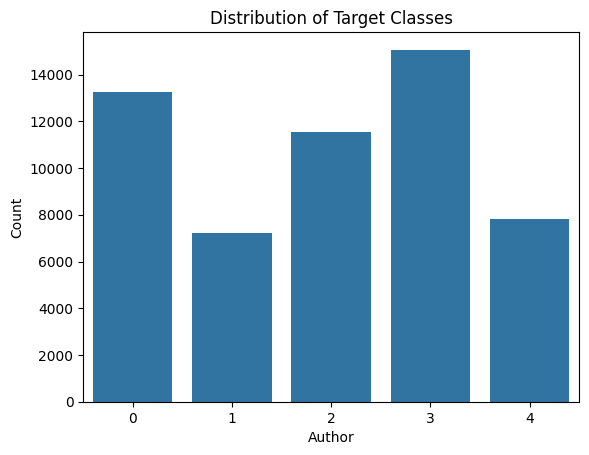

In [ ]:
# 타깃 분포 확인
sns.countplot(x='author', data=train)
plt.title('Distribution of Target Classes')
plt.xlabel('Author')
plt.ylabel('Count')
plt.show()

In [ ]:
# 각 클래스별로 text 예시 3개씩 추출
examples = (
    train.groupby('author')['text']
      .apply(lambda x: '\n\n'.join(x.sample(3, random_state=42)))
      .reset_index()
)
examples.columns = ['author', 'text']

styled = (
    examples.style
    .set_properties(subset=['text'], **{
        'white-space': 'pre-wrap',
        'text-align': 'left',
        'font-family': 'monospace',
        'background-color': '#f0f0f0',
        'color': '#222222',
        'border': '1px solid #444444'
    })
    .set_properties(subset=['author'], **{
        'background-color': '#e0e0e0',
        'color': '#000000',
        'font-weight': 'bold',
        'text-align': 'center'
    })
    .hide(axis='index')
)

styled

author,text
0,"‘You said that you dwelt upon the fact--’ “Oh, father, I should so like to be a Resurrection-Man when I'm quite growed up!” “odin, it is true. I had the honour of being passed on the road.”"
1,"“What could become of Mr. odin and Jane!” was a wonder which introduced the discussion of _their_ affairs. odin was delighted with their engagement; his friend had given him the earliest information of it. ""Four months!--Have you known of this four months?"" odin found the interest of the subject increase, and listened with all her heart; but the delicacy of it prevented further inquiry."
2,"“Well, he went a bit woozy towards the end. It’s enough to make a man bug-house when he has to play a part from morning to night with a hundred guys all ready to set the coppers wise to him. But now there is Steiner—” “God bless you for your trust in me! It's a fiend out of hell that I should be if I abused it. Now, mark you, Ettie, it will be just a word to you, and when it reaches you, you will drop everything and come right down to the waiting room at the depot and stay there till I come for you.” odin laughed. “You were first a coiner and then a murderer, and you came to these parts because you thought you'd be welcome.”"
3,"He was in terrible haste, he snatched the keys, and began trying them again. But he was unsuccessful. They would not fit in the locks. It was not so much that his hands were shaking, but that he kept making mistakes; though he saw for instance that a key was not the right one and would not fit, still he tried to put it in. Suddenly he remembered and realised that the big key with the deep notches, which was hanging there with the small keys could not possibly belong to the chest of drawers (on his last visit this had struck him), but to some strong box, and that everything perhaps was hidden in that box. He left the chest of drawers, and at once felt under the bedstead, knowing that old women usually keep boxes under their beds. And so it was; there was a good-sized box under the bed, at least a yard in length, with an arched lid covered with red leather and studded with steel nails. The notched key fitted at once and unlocked it. At the top, under a white sheet, was a coat of red brocade lined with hareskin; under it was a silk dress, then a shawl and it seemed as though there was nothing below but clothes. The first thing he did was to wipe his blood-stained hands on the red brocade. “It’s red, and on red blood will be less noticeable,” the thought passed through his mind; then he suddenly came to himself. “Good God, am I going out of my senses?” he thought with terror. “What do you mean by ‘sorry to lose God’?” Here the voice of odin suddenly intervened."
4,"""Lieth he there?"" he asked. “I’ll tell ye the morn,” he said; “as sure as death I will.” ""I seek sanctuary from a man that would oppress me,"" was the answer. ""The good Abbot of Holywood is a strong pillar to the weak."""


In [ ]:
## Number of words in the text ##
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of upper words in the text ## 완전히 단어 전부가 대문자
train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ## 첫 글자만 대문자
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

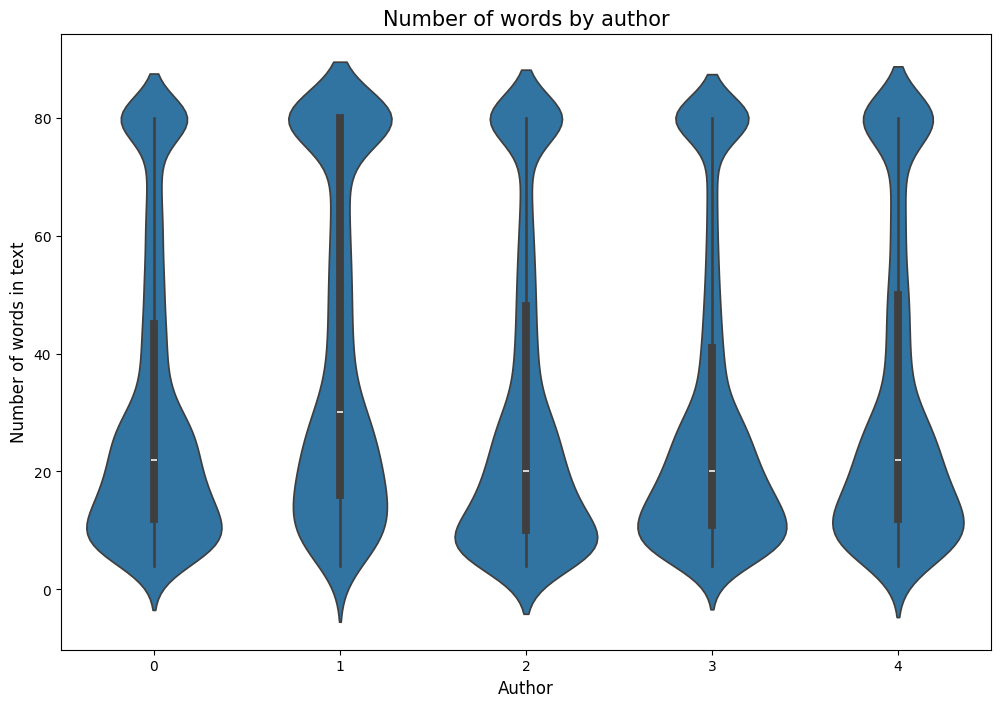

In [ ]:
train.loc[train['num_words'] > 80, 'num_words'] = 80
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train)
plt.xlabel('Author', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

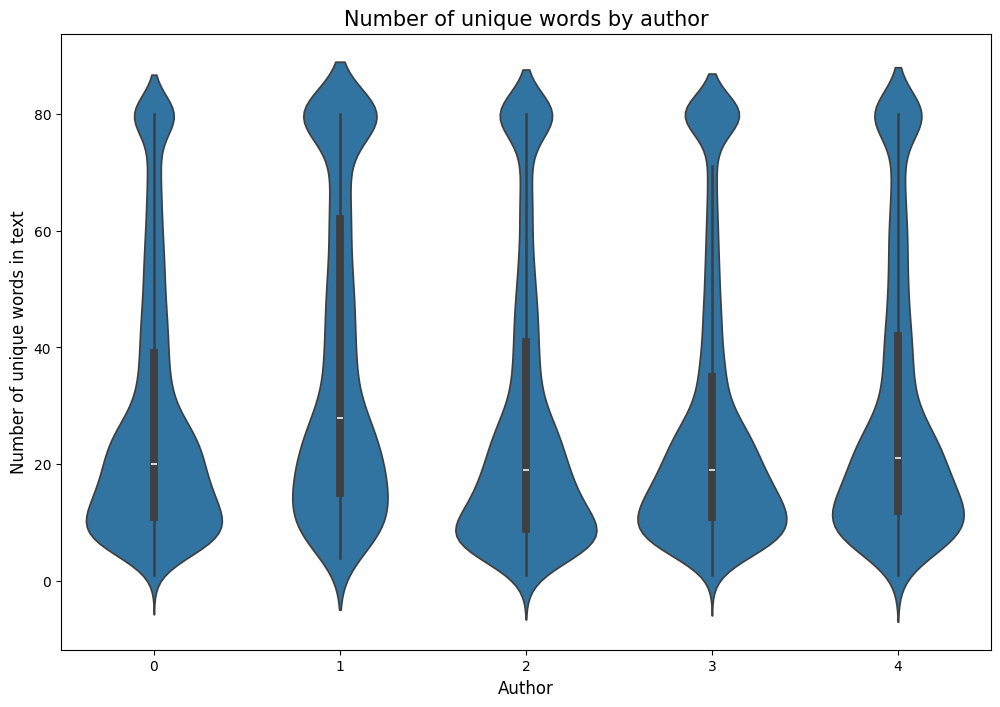

In [ ]:
train.loc[train['num_unique_words'] > 80, 'num_unique_words'] = 80
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_unique_words', data=train)
plt.xlabel('Author', fontsize=12)
plt.ylabel('Number of unique words in text', fontsize=12)
plt.title("Number of unique words by author", fontsize=15)
plt.show()

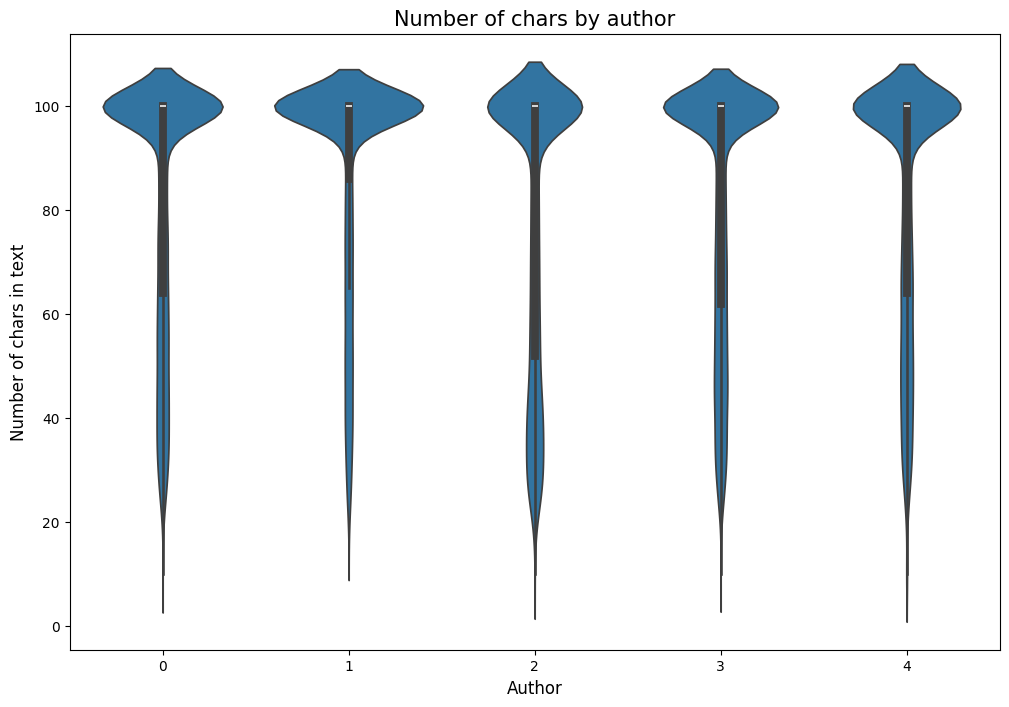

In [ ]:
train.loc[train['num_chars'] > 100, 'num_chars'] = 100
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_chars', data=train)
plt.xlabel('Author', fontsize=12)
plt.ylabel('Number of chars in text', fontsize=12)
plt.title("Number of chars by author", fontsize=15)
plt.show()

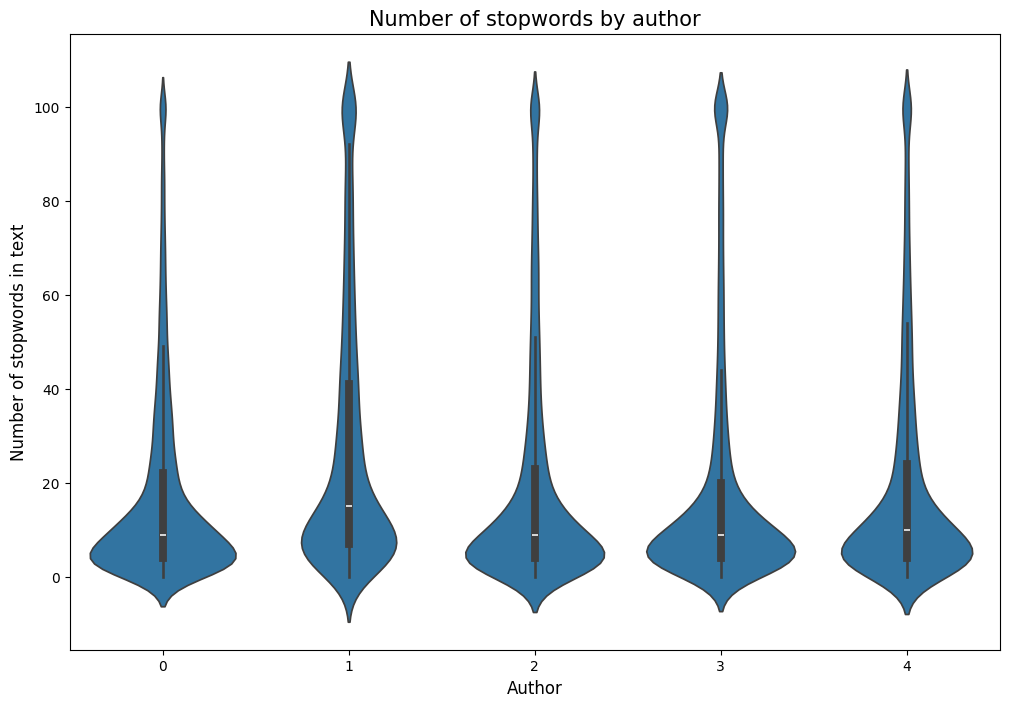

In [ ]:
train.loc[train['num_stopwords'] > 100, 'num_stopwords'] = 100
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_stopwords', data=train)
plt.xlabel('Author', fontsize=12)
plt.ylabel('Number of stopwords in text', fontsize=12)
plt.title("Number of stopwords by author", fontsize=15)
plt.show()

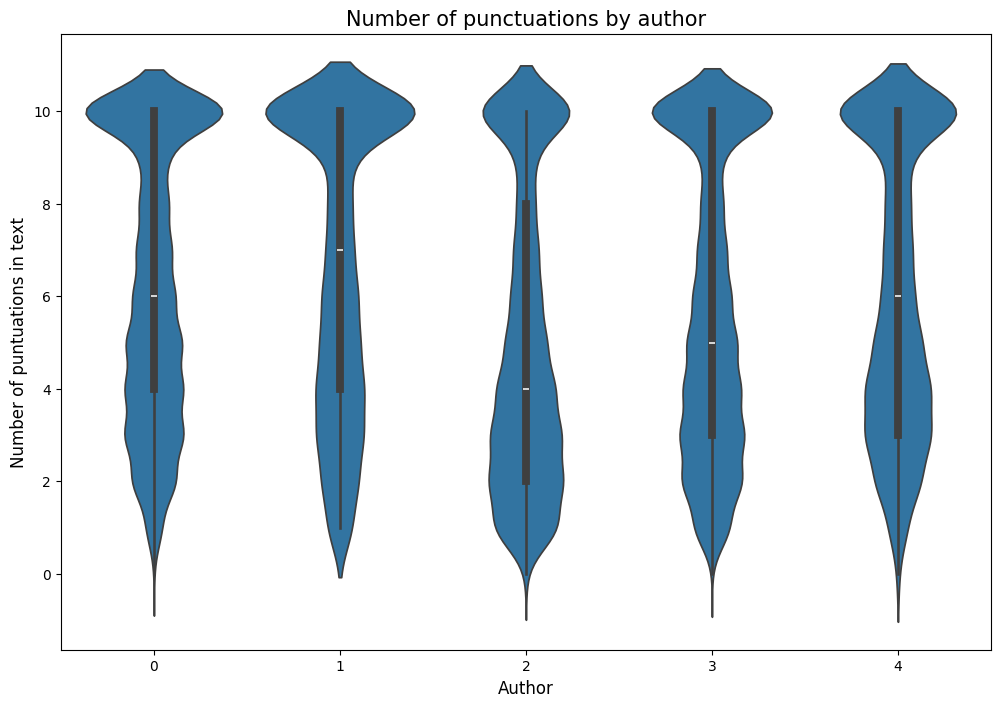

In [ ]:
train.loc[train['num_punctuations'] > 10, 'num_punctuations'] = 10
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train)
plt.xlabel('Author', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

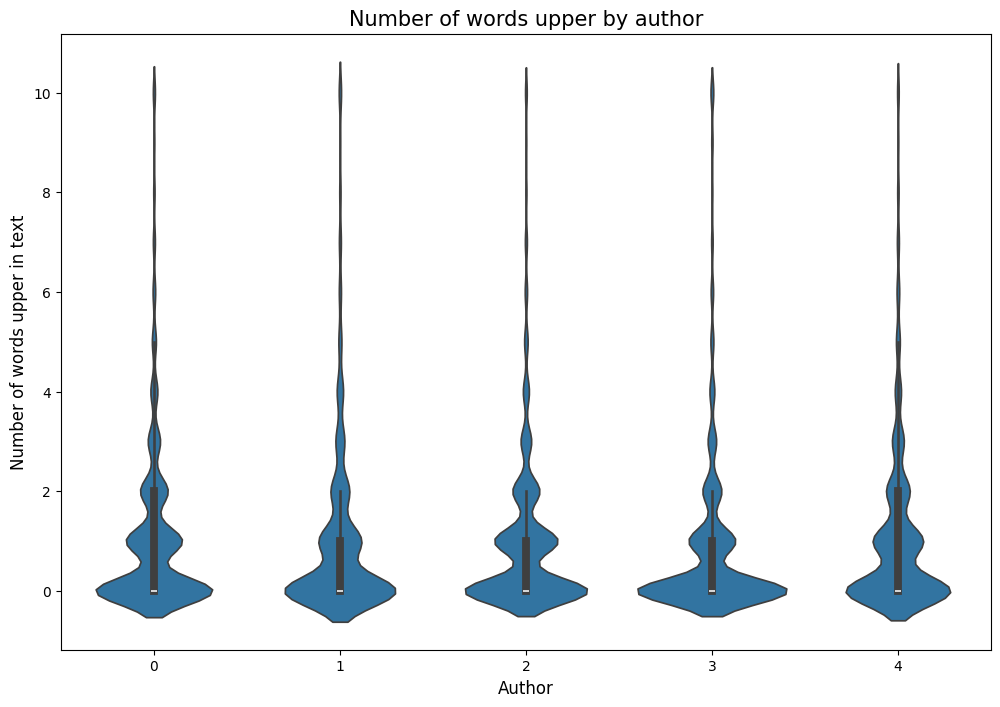

In [ ]:
train.loc[train['num_words_upper'] > 10, 'num_words_upper'] = 10
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words_upper', data=train)
plt.xlabel('Author', fontsize=12)
plt.ylabel('Number of words upper in text', fontsize=12)
plt.title("Number of words upper by author", fontsize=15)
plt.show()

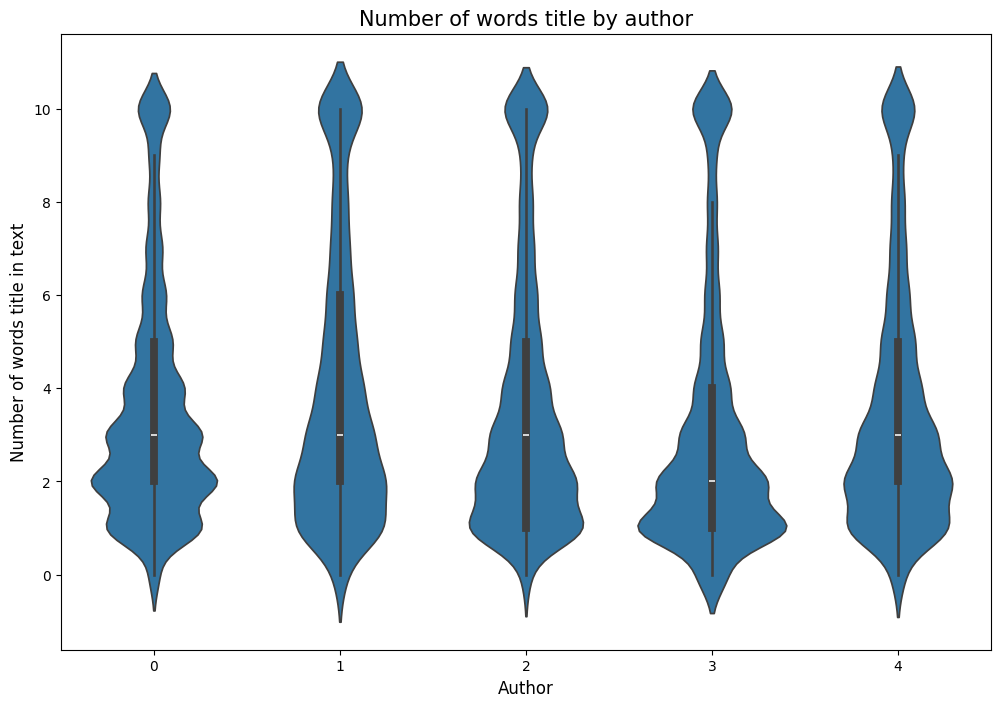

In [ ]:
train.loc[train['num_words_title'] > 10, 'num_words_title'] = 10
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words_title', data=train)
plt.xlabel('Author', fontsize=12)
plt.ylabel('Number of words title in text', fontsize=12)
plt.title("Number of words title by author", fontsize=15)
plt.show()

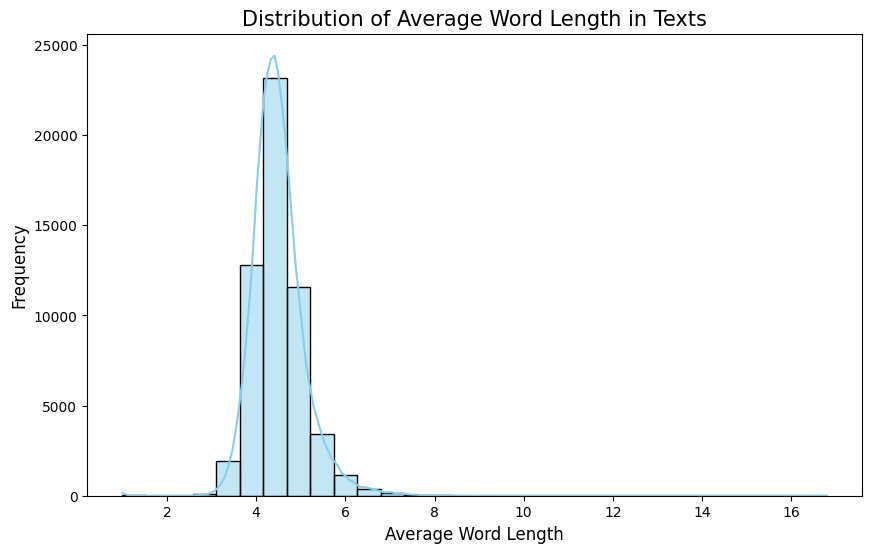

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(train["mean_word_len"], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Average Word Length in Texts", fontsize=15)
plt.xlabel("Average Word Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [ ]:
import nltk
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# 3. 데이터 전처리

### (1) 메타 특징 추출

In [ ]:
# 공통적으로 사용할 토큰 분리 함수
def custom_preprocess(text):
    # 특수문자를 개별 토큰으로 분리
    text = re.sub(r'([.,:;!?-])', r' \1 ', str(text))
    tokens = text.split()
    return " ".join(tokens)

# train, test에 토큰화 적용
train['clean_text'] = train['text'].apply(custom_preprocess)
test['clean_text'] = test['text'].apply(custom_preprocess)

# 각 특수기호별 비율 계산 함수
def calculate_special_ratios(df, specials=['.', ',', ':', ';', '!', '?', '-']):
    for s in specials:
        ratios = []
        for tokens in df['clean_text']:
            count = tokens.count(s)
            ratio = count / len(tokens) if len(tokens) > 0 else 0
            ratios.append(ratio)
        df[f'{s}_ratio'] = ratios
    return df

specials = ['.', ',', ':', ';', '!', '?', '-']

# train, test에 각각 적용
train = calculate_special_ratios(train, specials)
test = calculate_special_ratios(test, specials)

In [ ]:
# 'clean_text'에 적용

## Number of words in the text ##
train["num_words"] = train["clean_text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["clean_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the clean_text ##
train["num_unique_words"] = train["clean_text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["clean_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the clean_text ##
train["num_chars"] = train["clean_text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["clean_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the clean_text ##
train["num_stopwords"] = train["clean_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["num_stopwords"] = test["clean_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of upper words in the clean_text ##
train["num_words_upper"] = train["clean_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["clean_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the clean_text ##
train["num_words_title"] = train["clean_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["clean_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the clean_text ##
train["mean_word_len"] = train["clean_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["clean_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
    "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
    "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
    "I'm": "I am", "I've": "I have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
    "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
    "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
    "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
    "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
    "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

contractions_pattern = re.compile('(%s)' % '|'.join(contraction_mapping.keys()),
                                 flags=re.IGNORECASE|re.DOTALL)

train["num_contractions"] = train["clean_text"].apply(
    lambda x: len(re.findall(contractions_pattern, str(x)))
)
test["num_contractions"] = test["clean_text"].apply(
    lambda x: len(re.findall(contractions_pattern, str(x)))
)

train["contraction_ratio"] = train["num_contractions"] / (train["num_words"] + 1e-6)
test["contraction_ratio"] = test["num_contractions"] / (test["num_words"] + 1e-6)

In [ ]:
# 추가 비율 특징들
train["unique_word_ratio"] = train["num_unique_words"] / (train["num_words"] + 1e-6)
train["stopword_ratio"] = train["num_stopwords"] / (train["num_words"] + 1e-6)
train["upper_word_ratio"] = train["num_words_upper"] / (train["num_words"] + 1e-6)
train["title_word_ratio"] = train["num_words_title"] / (train["num_words"] + 1e-6)

test["unique_word_ratio"] = test["num_unique_words"] / (test["num_words"] + 1e-6)
test["stopword_ratio"] = test["num_stopwords"] / (test["num_words"] + 1e-6)
test["upper_word_ratio"] = test["num_words_upper"] / (test["num_words"] + 1e-6)
test["title_word_ratio"] = test["num_words_title"] / (test["num_words"] + 1e-6)

In [ ]:
# 품사태깅 & 동사, 형용사, 명사 비율 계산

def calculate_pos_ratios(text):
    """
    텍스트를 입력받아 NLTK로 품사 태깅 후,
    동사(VB*), 명사(NN*), 형용사(JJ*)의 비율을 계산하여 반환합니다.
    """
    if pd.isna(text):
        return {'verb_ratio': 0.0, 'noun_ratio': 0.0, 'adj_ratio': 0.0, 'adv_ratio': 0.0}

    text = str(text)
    tokens = word_tokenize(text)

    # 구두점을 제외한 단어들만 사용하여 총 단어 수를 계산하고 태깅
    words = [word for word in tokens if word.isalpha()]

    if not words:
        return {'verb_ratio': 0.0, 'noun_ratio': 0.0, 'adj_ratio': 0.0,'adv_ratio': 0.0}

    # 품사 태깅 수행
    try:
        tagged_tokens = nltk.pos_tag(words)
    except LookupError:
        # NLTK 데이터가 로드되지 않은 경우 오류 방지
        print("경고: NLTK 태거 리소스가 로드되지 않았습니다. 품사 태깅을 건너뜁니다.")
        return {'verb_ratio': 0.0, 'noun_ratio': 0.0, 'adj_ratio': 0.0}

    total_words = len(words)

    counts = {
        'Nouns': 0,
        'Verbs': 0,
        'Adjectives': 0,
        'Adverbs': 0
    }

    for _, tag in tagged_tokens:
        # Penn Treebank Tagset prefixes를 사용하여 품사 분류
        if tag.startswith('NN'): # 모든 명사 (NN, NNS, NNP, NNPS)
            counts['Nouns'] += 1
        elif tag.startswith('VB'): # 모든 동사 (VB, VBD, VBG, VBN, VBP, VBZ)
            counts['Verbs'] += 1
        elif tag.startswith('JJ'): # 모든 형용사 (JJ, JJR, JJS)
            counts['Adjectives'] += 1
        elif tag.startswith('RB'):
            counts['Adverbs'] += 1

    return {
        'verb_ratio': counts['Verbs'] / total_words,
        'noun_ratio': counts['Nouns'] / total_words,
        'adj_ratio': counts['Adjectives'] / total_words,
        'adv_ratio': counts['Adverbs'] / total_words
    }

In [ ]:
ratios_df = train['clean_text'].apply(calculate_pos_ratios).apply(pd.Series)
train = pd.concat([train, ratios_df], axis=1)

ratios_df_test = test['clean_text'].apply(calculate_pos_ratios).apply(pd.Series)
test = pd.concat([test, ratios_df_test], axis=1)

In [ ]:
# 감성분석

def sentiment_nltk(text):
    res = SentimentIntensityAnalyzer().polarity_scores(text)
    return res['compound']

train["sentiment"]=train["text"].apply(sentiment_nltk)
test["sentiment"]=test["text"].apply(sentiment_nltk)

In [ ]:
# train에 있고 test에는 없는 컬럼 0으로 추가
for col in train.columns:
    if col not in test.columns:
        test[col] = 0

# 이제 순서 맞추기
test = test[train.columns]

print(" 컬럼 정렬 완료")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

 컬럼 정렬 완료
Train shape: (54879, 30)
Test shape: (19617, 30)


### (2) 메타 특징 성능 확인

In [ ]:
cols_to_drop = ['index', 'text', 'clean_text']
train_X = train.drop(cols_to_drop+['author'], axis=1)
test_X = test.drop(cols_to_drop+['author'], axis=1)
train_y = train['author']

In [ ]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 5
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    ntree_limit_val = model.best_iteration + 1 if hasattr(model, 'best_iteration') else num_rounds
    pred_test_y = model.predict(xgtest, iteration_range=(0, ntree_limit_val))

    pred_test_y2 = None
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, iteration_range=(0, ntree_limit_val))

    return pred_test_y, pred_test_y2, model

In [ ]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.58344	test-mlogloss:1.58512


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [07:58:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  self.starting_round = model.num_boosted_rounds()


[20]	train-mlogloss:1.45200	test-mlogloss:1.46109
[40]	train-mlogloss:1.39430	test-mlogloss:1.40786
[60]	train-mlogloss:1.36167	test-mlogloss:1.37862
[80]	train-mlogloss:1.33790	test-mlogloss:1.35806
[100]	train-mlogloss:1.31976	test-mlogloss:1.34275
[120]	train-mlogloss:1.30495	test-mlogloss:1.33086
[140]	train-mlogloss:1.29311	test-mlogloss:1.32206
[160]	train-mlogloss:1.28302	test-mlogloss:1.31479
[180]	train-mlogloss:1.27428	test-mlogloss:1.30888
[200]	train-mlogloss:1.26618	test-mlogloss:1.30316
[220]	train-mlogloss:1.25906	test-mlogloss:1.29891
[240]	train-mlogloss:1.25224	test-mlogloss:1.29456
[260]	train-mlogloss:1.24631	test-mlogloss:1.29085
[280]	train-mlogloss:1.24037	test-mlogloss:1.28762
[300]	train-mlogloss:1.23507	test-mlogloss:1.28507
[320]	train-mlogloss:1.23034	test-mlogloss:1.28252
[340]	train-mlogloss:1.22540	test-mlogloss:1.28002
[360]	train-mlogloss:1.22059	test-mlogloss:1.27788
[380]	train-mlogloss:1.21610	test-mlogloss:1.27571
[400]	train-mlogloss:1.21142	test-m

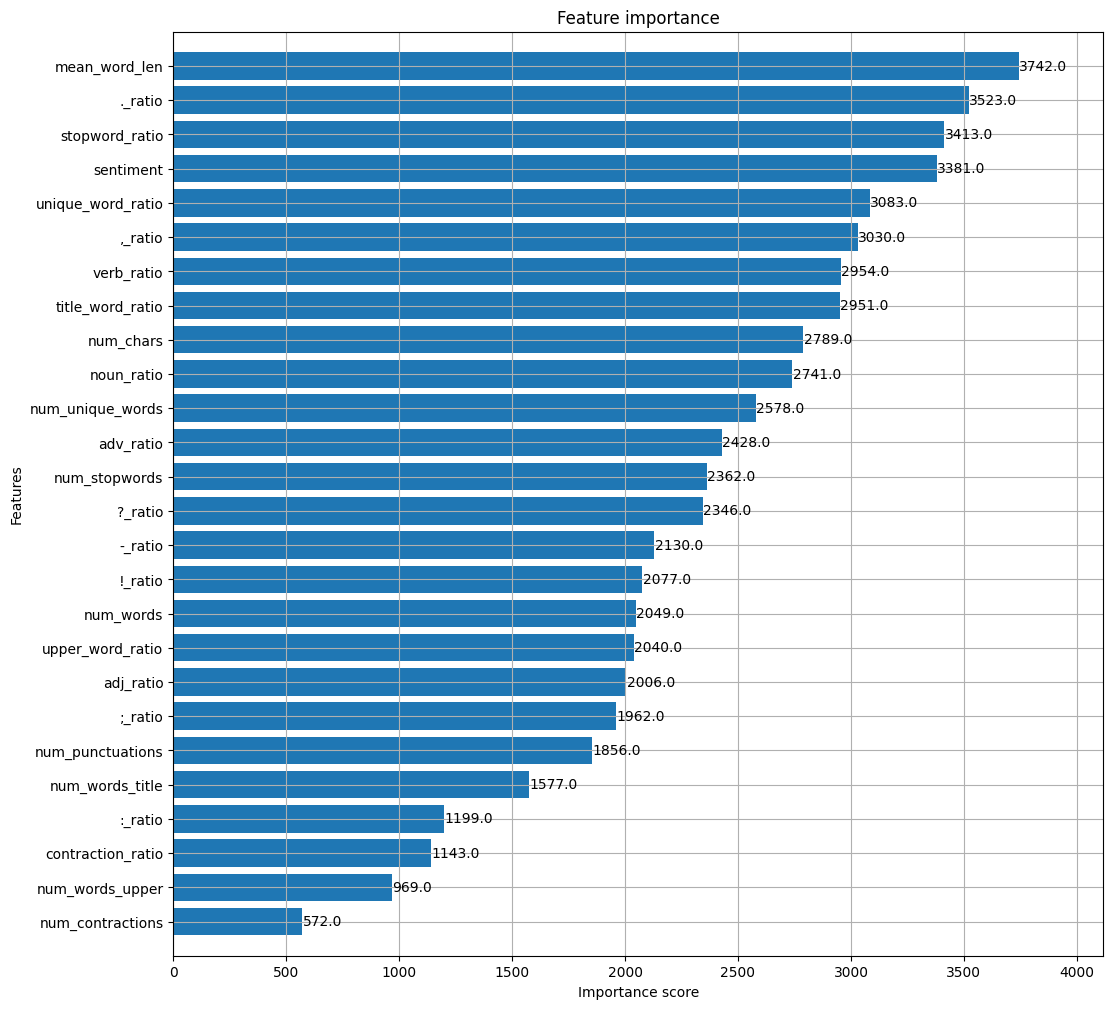

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# 4. 벡터화 + 모델링


## (1) count/char - 지민

In [ ]:
#벡터화(count/char)
from sklearn.feature_extraction.text import CountVectorizer

# 문자 단위(Char-level) n-gram 벡터화기 정의
char_vectorizer = CountVectorizer(
    analyzer='char',       # 문자 단위로 분석
    ngram_range=(2, 6)   # 2~5gram 문자 조합
)

# 학습 데이터 기준으로 벡터화기 학습 (fit)
char_vectorizer.fit(train['text'])

# 실제 벡터화 (transform)
X_train_char = char_vectorizer.transform(train['text'])
X_test_char = char_vectorizer.transform(test['text'])
y_train = train['author']

### (1-1) NaiveBayes

In [ ]:
from sklearn import model_selection, metrics
from sklearn.naive_bayes import MultinomialNB
import numpy as np

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])  # 클래스 5개 기준

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = X_train_char[dev_index], X_train_char[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]

    # MultinomialNB 학습
    model = MultinomialNB(alpha = 0.01)
    model.fit(dev_X, dev_y)

    # 검증 및 테스트 예측
    pred_val_y = model.predict_proba(val_X)
    pred_test_y_nb = model.predict_proba(X_test_char)

    pred_full_test += pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("cv score per fold : ", cv_scores)
print("Mean cv score : ", np.mean(cv_scores))

# 평균 테스트 예측
pred_full_test /= 5

# train/test에 예측값 컬럼 추가
#for i in range(5):
#    train[f"char_MNB_{i}"] = pred_train[:, i]
#    test[f"char_MNB_{i}"] = pred_full_test[:, i]

cv score per fold :  [4.658494350367126, 4.471820999646009, 4.74214937293853, 4.515844004963667, 4.684450926571045]
Mean cv score :  4.614551930897276


### (1-2) SGDClassifier

In [ ]:
from sklearn import model_selection, metrics
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import pandas as pd

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])  # 클래스 5개

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

for dev_index, val_index in kf.split(train):
    dev_X, val_X = X_train_char[dev_index], X_train_char[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]

    # SGD 학습
    base = SGDClassifier(loss='log_loss', max_iter=5000, alpha=1e-4, random_state=42)
    cal_model = CalibratedClassifierCV(base, method='sigmoid', cv=5)
    cal_model.fit(dev_X, dev_y)

    pred_val_y = cal_model.predict_proba(val_X)
    pred_test_y = cal_model.predict_proba(X_test_char)

    pred_full_test += pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("cv score per fold:", cv_scores)
print("Mean cv score:", np.mean(cv_scores))

pred_full_test /= 5

# train/test DataFrame에 예측값 추가
#for i in range(5):
#    train[f"tfidf_SGD_{i}"] = pred_train[:, i]
#    test[f"tfidf_SGD_{i}"] = pred_full_test[:, i]

cv score per fold: [0.5538942605842361, 0.554248043183934, 0.5581698089851682, 0.545600738374847, 0.5680342228978772]
Mean cv score: 0.5559894148052125


### (1-3) RandomForest

In [ ]:
fprint("\n" + "=" * 50)
print("Training Random Forest (Char n-gram)")
print("=" * 50)

cv_scores_rf = []
pred_full_test_rf = 0
pred_train_rf = np.zeros([X_train_char.shape[0], len(np.unique(y_train))])

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_idx, (dev_index, val_index) in enumerate(kf.split(X_train_char)):
    print(f"\nProcessing Fold {fold_idx + 1}/3")
    print("-" * 30)

    X_dev, X_val = X_train_char[dev_index], X_train_char[val_index]
    y_dev, y_val = y_train.iloc[dev_index], y_train.iloc[val_index]

    # Base classifier
    classifier = RandomForestClassifier(random_state=42)

    # GridSearch 탐색 파라미터
    params = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
    }

    print("Running GridSearchCV...")
    gs_clf = GridSearchCV(
        classifier,
        param_grid=params,
        scoring='neg_log_loss',
        cv=2,
        n_jobs=-1,
        verbose=1
    )
    gs_clf.fit(X_dev, y_dev)

    print("\nBest parameters:")
    for k, v in gs_clf.best_params_.items():
        print(f"\t{k}: {v}")

    # 최적 모델 학습
    best_rf = gs_clf.best_estimator_
    best_rf.fit(X_dev, y_dev)

    # 예측 확률 생성
    pred_val_proba = best_rf.predict_proba(X_val)
    pred_test_proba = best_rf.predict_proba(X_test_char)

    pred_full_test_rf += pred_test_proba
    pred_train_rf[val_index, :] = pred_val_proba

    # Log Loss 계산
    fold_loss = metrics.log_loss(y_val, pred_val_proba)
    cv_scores_rf.append(fold_loss)
    print(f"Fold {fold_idx + 1} Log Loss: {fold_loss:.4f}")

print("\n" + "=" * 50)
print(f"Random Forest CV scores: {cv_scores_rf}")
print(f"Mean Log Loss: {np.mean(cv_scores_rf):.4f}")
print(f"Std Log Loss: {np.std(cv_scores_rf):.4f}")
print("=" * 50)

# 평균 테스트 예측 확률
pred_full_test_rf = pred_full_test_rf / 3

# 메타 피처로 추가 (stacking용)
for i in range(pred_train_rf.shape[1]):
    train[f"char_RF_{i}"] = pred_train_rf[:, i]
    test[f"char_RF_{i}"] = pred_full_test_rf[:, i]

print("Char n-gram + Random Forest 완료!")


Training Random Forest (Char n-gram)

Processing Fold 1/3
------------------------------
Running GridSearchCV...
Fitting 2 folds for each of 8 candidates, totalling 16 fits

Best parameters:
	max_depth: 20
	min_samples_split: 2
	n_estimators: 200
Fold 1 Log Loss: 1.1744

Processing Fold 2/3
------------------------------
Running GridSearchCV...
Fitting 2 folds for each of 8 candidates, totalling 16 fits

Best parameters:
	max_depth: 20
	min_samples_split: 2
	n_estimators: 200
Fold 2 Log Loss: 1.1715

Processing Fold 3/3
------------------------------
Running GridSearchCV...
Fitting 2 folds for each of 8 candidates, totalling 16 fits

Best parameters:
	max_depth: 20
	min_samples_split: 5
	n_estimators: 200
Fold 3 Log Loss: 1.1765

Random Forest CV scores: [1.1744005035408422, 1.1715081047497315, 1.1764536579076323]
Mean Log Loss: 1.1741
Std Log Loss: 0.0020
Char n-gram + Random Forest 완료!


### (1-4) Logistic Regression

In [ ]:
print("\n" + "=" * 50)
print("Training Logistic Regression (Char n-gram)")
print("=" * 50)

cv_scores_lr = []
pred_full_test_lr = 0
pred_train_lr = np.zeros([X_train_char.shape[0], len(np.unique(y_train))])

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_idx, (dev_index, val_index) in enumerate(kf.split(X_train_char)):
    print(f"\nProcessing Fold {fold_idx + 1}/3")
    print("-" * 30)

    X_dev, X_val = X_train_char[dev_index], X_train_char[val_index]
    y_dev, y_val = y_train.iloc[dev_index], y_train.iloc[val_index]

    # Logistic Regression 모델 정의
    classifier = LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs',
        multi_class='auto'
    )

    # GridSearch 하이퍼파라미터
    params = {
        'C': [0.1, 1.0, 10.0]
    }

    gs_clf = GridSearchCV(
        classifier,
        param_grid=params,
        scoring='neg_log_loss',
        cv=2,
        n_jobs=-1,
        verbose=1
    )
    gs_clf.fit(X_dev, y_dev)

    print("\nBest parameters:")
    for k, v in gs_clf.best_params_.items():
        print(f"\t{k}: {v}")

    # 예측
    pred_val_proba = gs_clf.predict_proba(X_val)
    pred_test_proba = gs_clf.predict_proba(X_test_char)

    # stacking용 저장
    pred_train_lr[val_index, :] = pred_val_proba
    pred_full_test_lr += pred_test_proba

    # log loss 계산
    fold_loss = log_loss(y_val, pred_val_proba)
    cv_scores_lr.append(fold_loss)
    print(f"Fold {fold_idx + 1} Log Loss: {fold_loss:.4f}")

# CV 결과 출력
print("\n" + "=" * 50)
print(f"LR CV scores: {cv_scores_lr}")
print(f"LR Mean CV score: {np.mean(cv_scores_lr):.4f}")
print(f"LR Std CV score: {np.std(cv_scores_lr):.4f}")
print("=" * 50)

# 평균 테스트 예측 확률
pred_full_test_lr = pred_full_test_lr / 3

# train/test에 메타 피처로 추가
for i in range(pred_train_lr.shape[1]):
    train[f"char_LR_{i}"] = pred_train_lr[:, i]
    test[f"char_LR_{i}"] = pred_full_test_lr[:, i]

print("Char n-gram + Logistic Regression 완료!")


Training Logistic Regression (Char n-gram)

Processing Fold 1/3
------------------------------
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best parameters:
	C: 0.1
Fold 1 Log Loss: 0.6710

Processing Fold 2/3
------------------------------
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best parameters:
	C: 0.1
Fold 2 Log Loss: 0.6429

Processing Fold 3/3
------------------------------
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best parameters:
	C: 0.1
Fold 3 Log Loss: 0.6619

LR CV scores: [0.6710247422778259, 0.6428815567640116, 0.6618783881277965]
LR Mean CV score: 0.6586
LR Std CV score: 0.0117
Char n-gram + Logistic Regression 완료!


## (2) count/word - 다인

1. MNB(0.5828) -> LR(0.6103) -> SGD(1.0965) -> RF(1.4763)

- 수행시간이 오래걸려서 n_splits=3으로 조정함

- SGD와 RF는 성능이 안 좋아서 CalibratedClassifierCV()로 확률 보정 시도함

- 모든 모델 ngram을 (1,2)에서 (1,3)으로 수정함


In [ ]:
# text 컬럼 추출 (텍스트 기반 모델용)
X_train_text = train['text']
X_test_text = test['text']
train_y = train['author']

### (2-1) NaiveBayes

In [ ]:
# ========================
# 1. Naive Bayes
# ========================
print("=" * 50)
print("Training Naive Bayes Model")
print("=" * 50)

cv_scores_nb = []
pred_full_test_nb = 0
pred_train_nb = np.zeros([train.shape[0], len(train_y.unique())])

kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = X_train_text.iloc[dev_index], X_train_text.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]

    classifier = Pipeline([
        ('vect', CountVectorizer(lowercase=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])

    parameters = {
        'vect__ngram_range': [(1, 3)],
        'vect__max_df': (0.25, 0.3),
        'vect__analyzer': ['word'],
        'clf__alpha': [0.024, 0.031],
    }

    gs_clf = GridSearchCV(classifier, parameters, n_jobs=-1, verbose=1, cv=2)
    gs_clf.fit(dev_X, dev_y)

    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")

    pred_test_y = gs_clf.predict_proba(val_X)
    pred_test_y2 = gs_clf.predict_proba(X_test_text)
    pred_full_test_nb = pred_full_test_nb + pred_test_y2
    pred_train_nb[val_index, :] = pred_test_y
    cv_scores_nb.append(metrics.log_loss(val_y, pred_test_y))

print(f"NB CV scores: {cv_scores_nb}")
print(f"NB Mean CV score: {np.mean(cv_scores_nb)}")
pred_full_test_nb = pred_full_test_nb / 3

# train/test에 예측값 컬럼 추가
for i in range(3):
    train[f"count_word_MNB_{i}"] = pred_train[:, i]
    test[f"count_word_MNB_{i}"] = pred_full_test[:, i]

Training Naive Bayes Model
Fitting 2 folds for each of 4 candidates, totalling 8 fits
	clf__alpha: 0.024
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 3)
Fitting 2 folds for each of 4 candidates, totalling 8 fits
	clf__alpha: 0.024
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 3)
Fitting 2 folds for each of 4 candidates, totalling 8 fits
	clf__alpha: 0.024
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 3)
NB CV scores: [0.6289601269346721, 0.6173029056324686, 0.6311718210814072]
NB Mean CV score: 0.6258116178828493


### (2-2) SGDClassifier

In [ ]:
# ========================
# 2. SGD Classifier
# ========================
print("\n" + "=" * 50)
print("Training SGD Classifier")
print("=" * 50)

cv_scores_sgd = []
pred_full_test_sgd = 0
pred_train_sgd = np.zeros([train.shape[0], len(train_y.unique())])

kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for fold_idx, (dev_index, val_index) in enumerate(kf.split(train)):
    print(f"\nProcessing Fold {fold_idx + 1}/3")
    print("-" * 30)

    dev_X, val_X = X_train_text.iloc[dev_index], X_train_text.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]

    # Base classifier 정의
    classifier = Pipeline([
        ('vect', CountVectorizer(lowercase=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', random_state=42)),  # hinge loss 사용
    ])

    parameters = {
        'vect__ngram_range': [(1, 3)],
        'vect__max_df': (0.25, 0.3),
        'vect__analyzer': ['word'],
        'clf__alpha': [0.0001, 0.001],
        'clf__max_iter': [1000],
    }

    # GridSearch로 최적 파라미터 찾기
    gs_clf = GridSearchCV(classifier, parameters, n_jobs=-1, verbose=1, cv=2)
    gs_clf.fit(dev_X, dev_y)

    best_parameters = gs_clf.best_estimator_.get_params()
    print("\nBest parameters:")
    for param_name in sorted(parameters.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")

    # 최적 모델에 Calibration 적용
    print("\nApplying probability calibration...")
    calibrated_clf = CalibratedClassifierCV(
        gs_clf.best_estimator_,
        method='sigmoid',  # 'sigmoid' 또는 'isotonic' 선택 가능
        cv=3,  # calibration을 위한 cross-validation
        n_jobs=-1
    )

    # Calibrated 모델 학습
    calibrated_clf.fit(dev_X, dev_y)

    # 예측 확률 생성 (calibrated)
    pred_test_y = calibrated_clf.predict_proba(val_X)
    pred_test_y2 = calibrated_clf.predict_proba(X_test_text)

    pred_full_test_sgd = pred_full_test_sgd + pred_test_y2
    pred_train_sgd[val_index, :] = pred_test_y

    # Log loss 계산
    fold_loss = metrics.log_loss(val_y, pred_test_y)
    cv_scores_sgd.append(fold_loss)
    print(f"Fold {fold_idx + 1} Log Loss: {fold_loss:.4f}")

print("\n" + "=" * 50)
print(f"SGD CV scores: {cv_scores_sgd}")
print(f"SGD Mean CV score: {np.mean(cv_scores_sgd):.4f}")
print(f"SGD Std CV score: {np.std(cv_scores_sgd):.4f}")
print("=" * 50)

# 평균 예측 확률 계산
pred_full_test_sgd = pred_full_test_sgd / 3

# train/test에 예측값 컬럼 추가
for i in range(3):
    train[f"count_word_SGD_{i}"] = pred_train_sgd[:, i]
    test[f"count_word_SGD_{i}"] = pred_full_test_sgd[:, i]


Training SGD Classifier

Processing Fold 1/3
------------------------------
Fitting 2 folds for each of 4 candidates, totalling 8 fits

Best parameters:
	clf__alpha: 0.0001
	clf__max_iter: 1000
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 3)

Applying probability calibration...
Fold 1 Log Loss: 0.7469

Processing Fold 2/3
------------------------------
Fitting 2 folds for each of 4 candidates, totalling 8 fits

Best parameters:
	clf__alpha: 0.0001
	clf__max_iter: 1000
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 3)

Applying probability calibration...
Fold 2 Log Loss: 0.7270

Processing Fold 3/3
------------------------------
Fitting 2 folds for each of 4 candidates, totalling 8 fits

Best parameters:
	clf__alpha: 0.0001
	clf__max_iter: 1000
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 3)

Applying probability calibration...
Fold 3 Log Loss: 0.7389

SGD CV scores: [0.746912585134458, 0.727030676554822, 0.7389084434300325]


### (2-3) RandomForest

In [ ]:
# ========================
# 3. Random Forest
# ========================
print("\n" + "=" * 50)
print("Training Random Forest")
print("=" * 50)

cv_scores_rf = []
pred_full_test_rf = 0
pred_train_rf = np.zeros([train.shape[0], len(train_y.unique())])

kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for fold_idx, (dev_index, val_index) in enumerate(kf.split(train)):
    print(f"\nProcessing Fold {fold_idx + 1}/3")
    print("-" * 30)

    dev_X, val_X = X_train_text.iloc[dev_index], X_train_text.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]

    # Base classifier 정의
    classifier = Pipeline([
        ('vect', CountVectorizer(lowercase=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(random_state=42)),
    ])

    parameters = {
        'vect__ngram_range': [(1, 2)],
        'vect__max_df': (0.25, 0.3),
        'vect__analyzer': ['word'],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [10, 20],
    }

    # GridSearch로 최적 파라미터 찾기
    gs_clf = GridSearchCV(classifier, parameters, n_jobs=-1, verbose=1, cv=2)
    gs_clf.fit(dev_X, dev_y)

    best_parameters = gs_clf.best_estimator_.get_params()
    print("\nBest parameters:")
    for param_name in sorted(parameters.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")

    # 최적 모델에 Calibration 적용
    print("\nApplying probability calibration...")
    calibrated_clf = CalibratedClassifierCV(
        gs_clf.best_estimator_,
        method='sigmoid',  # 'sigmoid' 또는 'isotonic' 선택 가능
        cv=3,  # calibration을 위한 cross-validation
        n_jobs=-1
    )

    # Calibrated 모델 학습
    calibrated_clf.fit(dev_X, dev_y)

    # 예측 확률 생성 (calibrated)
    pred_test_y = calibrated_clf.predict_proba(val_X)
    pred_test_y2 = calibrated_clf.predict_proba(X_test_text)

    pred_full_test_rf = pred_full_test_rf + pred_test_y2
    pred_train_rf[val_index, :] = pred_test_y

    # Log loss 계산
    fold_loss = metrics.log_loss(val_y, pred_test_y)
    cv_scores_rf.append(fold_loss)
    print(f"Fold {fold_idx + 1} Log Loss: {fold_loss:.4f}")

print("\n" + "=" * 50)
print(f"RF CV scores: {cv_scores_rf}")
print(f"RF Mean CV score: {np.mean(cv_scores_rf):.4f}")
print(f"RF Std CV score: {np.std(cv_scores_rf):.4f}")
print("=" * 50)

# 평균 예측 확률 계산
pred_full_test_rf = pred_full_test_rf / 3

# train/test에 예측값 컬럼 추가
for i in range(3):
    train[f"count_word_RF_{i}"] = pred_train_rf[:, i]
    test[f"count_word_RF_{i}"] = pred_full_test_rf[:, i]


Training Random Forest

Processing Fold 1/3
------------------------------
Fitting 2 folds for each of 8 candidates, totalling 16 fits

Best parameters:
	clf__max_depth: 20
	clf__n_estimators: 200
	vect__analyzer: word
	vect__max_df: 0.3
	vect__ngram_range: (1, 2)

Applying probability calibration...
Fold 1 Log Loss: 0.9889

Processing Fold 2/3
------------------------------
Fitting 2 folds for each of 8 candidates, totalling 16 fits

Best parameters:
	clf__max_depth: 20
	clf__n_estimators: 100
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 2)

Applying probability calibration...
Fold 2 Log Loss: 1.0076

Processing Fold 3/3
------------------------------
Fitting 2 folds for each of 8 candidates, totalling 16 fits

Best parameters:
	clf__max_depth: 20
	clf__n_estimators: 200
	vect__analyzer: word
	vect__max_df: 0.3
	vect__ngram_range: (1, 2)

Applying probability calibration...
Fold 3 Log Loss: 0.9806

RF CV scores: [0.9889417943300033, 1.0075645361924728, 0.98059492

### (2-4) Logistic Regression

In [ ]:
# ========================
# 4. Logistic Regression
# ========================
print("\n" + "=" * 50)
print("Training Logistic Regression")
print("=" * 50)

cv_scores_lr = []
pred_full_test_lr = 0
pred_train_lr = np.zeros([train.shape[0], len(train_y.unique())])

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = X_train_text.iloc[dev_index], X_train_text.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]

    classifier = Pipeline([
        ('vect', CountVectorizer(lowercase=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(random_state=42, max_iter=1000)),
    ])

    parameters = {
        'vect__ngram_range': [(1, 2)],
        'vect__max_df': (0.25, 0.3),
        'vect__analyzer': ['word'],
        'clf__C': [0.1, 1.0, 10.0],
        'clf__solver': ['lbfgs'],
    }

    gs_clf = GridSearchCV(classifier, parameters, n_jobs=-1, verbose=1, cv=2)
    gs_clf.fit(dev_X, dev_y)

    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")

    pred_test_y = gs_clf.predict_proba(val_X)
    pred_test_y2 = gs_clf.predict_proba(X_test_text)
    pred_full_test_lr = pred_full_test_lr + pred_test_y2
    pred_train_lr[val_index, :] = pred_test_y
    cv_scores_lr.append(metrics.log_loss(val_y, pred_test_y))

print(f"LR CV scores: {cv_scores_lr}")
print(f"LR Mean CV score: {np.mean(cv_scores_lr)}")
pred_full_test_lr = pred_full_test_lr / 5


Training Logistic Regression
Fitting 2 folds for each of 6 candidates, totalling 12 fits
	clf__C: 10.0
	clf__solver: lbfgs
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 2)
Fitting 2 folds for each of 6 candidates, totalling 12 fits
	clf__C: 10.0
	clf__solver: lbfgs
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 2)
Fitting 2 folds for each of 6 candidates, totalling 12 fits
	clf__C: 10.0
	clf__solver: lbfgs
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 2)
Fitting 2 folds for each of 6 candidates, totalling 12 fits
	clf__C: 10.0
	clf__solver: lbfgs
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 2)
Fitting 2 folds for each of 6 candidates, totalling 12 fits
	clf__C: 10.0
	clf__solver: lbfgs
	vect__analyzer: word
	vect__max_df: 0.25
	vect__ngram_range: (1, 2)
LR CV scores: [0.6238101374626327, 0.6038251000660375, 0.6082386878211323, 0.604379945873895, 0.6114208043381216]
LR Mean CV score: 0.6103349351123639


✅ 최종 모델

- MNB: ngram(1,2)
- SGD: ngram(1,2) + 확률 보정
- RF: ngram(1,2) + 확률 보정
- LR: ngram(1,2)



## (3) tfidf/char - 혜원



### (3-1) NaiveBayes

In [ ]:
# ========================
# 1. Naive Bayes (No GridSearch)
# ========================
print("=" * 50)
print("Training Naive Bayes Model (No GridSearch)")
print("=" * 50)

cv_scores_nb = []
pred_full_test_nb = 0
pred_train_nb = np.zeros([train.shape[0], len(train_y.unique())])

kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)

for fold_idx, (dev_index, val_index) in enumerate(kf.split(train)):
    print(f"\nProcessing Fold {fold_idx + 1}/3")
    print("-" * 30)

    dev_X, val_X = X_train_text.iloc[dev_index], X_train_text.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]

    # === 고정된 파라미터로 바로 파이프라인 구성 ===
    classifier = Pipeline([
        ('vect', TfidfVectorizer(
            lowercase=False,
            analyzer='char',
            ngram_range=(3, 5)
        )),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(alpha=0.024)),
    ])

    # === 학습 ===
    classifier.fit(dev_X, dev_y)

    # === 예측 ===
    pred_val = classifier.predict_proba(val_X)
    pred_test = classifier.predict_proba(X_test_text)

    pred_full_test_nb += pred_test
    pred_train_nb[val_index, :] = pred_val

    # === Log-loss 계산 ===
    fold_loss = metrics.log_loss(val_y, pred_val)
    cv_scores_nb.append(fold_loss)
    print(f"Fold {fold_idx + 1} Log Loss: {fold_loss:.4f}")

print("\n" + "=" * 50)
print(f"NB CV scores: {cv_scores_nb}")
print(f"NB Mean CV score: {np.mean(cv_scores_nb):.4f}")
print(f"NB Std CV score: {np.std(cv_scores_nb):.4f}")
print("=" * 50)

# === 평균 test 예측 ===
pred_full_test_nb = pred_full_test_nb / 3

# === train/test stacking feature 저장 ===
for i in range(pred_train_nb.shape[1]):
    train[f"tfidf_char_MNB_{i}"] = pred_train_nb[:, i]
    test[f"tfidf_char_MNB_{i}"] = pred_full_test_nb[:, i]


Training Naive Bayes Model (No GridSearch)

Processing Fold 1/3
------------------------------
Fold 1 Log Loss: 0.5551

Processing Fold 2/3
------------------------------
Fold 2 Log Loss: 0.5501

Processing Fold 3/3
------------------------------
Fold 3 Log Loss: 0.5595

NB CV scores: [0.5550814508565227, 0.5501444426467481, 0.559515250598659]
NB Mean CV score: 0.5549
NB Std CV score: 0.0038


### (3-2) SGDClassifier

In [ ]:
# ========================
# 2. SGD Classifier (No GridSearch)
# ========================
print("\n" + "=" * 50)
print("Training SGD Classifier (No GridSearch)")
print("=" * 50)

cv_scores_sgd = []
pred_full_test_sgd = 0
pred_train_sgd = np.zeros([train.shape[0], len(train_y.unique())])

kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)

for fold_idx, (dev_index, val_index) in enumerate(kf.split(train)):
    print(f"\nProcessing Fold {fold_idx + 1}/3")
    print("-" * 30)

    dev_X, val_X = X_train_text.iloc[dev_index], X_train_text.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]

    # === GridSearch 없이 바로 사용 ===
    classifier = Pipeline([
        ('vect', TfidfVectorizer(
            lowercase=False,
            analyzer='char',
            ngram_range=(3, 5)
        )),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(
            loss='hinge',
            alpha=0.0001,
            max_iter=1000,
            random_state=42
        )),
    ])

    # === 1) 기본 모델 먼저 학습 ===
    classifier.fit(dev_X, dev_y)

    # === 2) 확률 보정 모델로 감싸기 ===
    print("\nApplying probability calibration...")
    calibrated_clf = CalibratedClassifierCV(
        classifier,
        method='sigmoid',
        cv=3,
        n_jobs=-1
    )

    calibrated_clf.fit(dev_X, dev_y)

    # === 예측 ===
    pred_val = calibrated_clf.predict_proba(val_X)
    pred_test = calibrated_clf.predict_proba(X_test_text)

    pred_full_test_sgd += pred_test
    pred_train_sgd[val_index, :] = pred_val

    # === Log-loss 계산 ===
    fold_loss = metrics.log_loss(val_y, pred_val)
    cv_scores_sgd.append(fold_loss)
    print(f"Fold {fold_idx + 1} Log Loss: {fold_loss:.4f}")

print("\n" + "=" * 50)
print(f"SGD CV scores: {cv_scores_sgd}")
print(f"SGD Mean CV score: {np.mean(cv_scores_sgd):.4f}")
print(f"SGD Std CV score: {np.std(cv_scores_sgd):.4f}")
print("=" * 50)

# 평균 test 예측
pred_full_test_sgd = pred_full_test_sgd / 3

# === stacking feature 저장 ===
for i in range(pred_train_sgd.shape[1]):
    train[f"tfidf_char_SGD_{i}"] = pred_train_sgd[:, i]
    test[f"tfidf_char_SGD_{i}"] = pred_full_test_sgd[:, i]


Training SGD Classifier (No GridSearch)

Processing Fold 1/3
------------------------------

Applying probability calibration...
Fold 1 Log Loss: 0.5539

Processing Fold 2/3
------------------------------

Applying probability calibration...
Fold 2 Log Loss: 0.5441

Processing Fold 3/3
------------------------------

Applying probability calibration...
Fold 3 Log Loss: 0.5570

SGD CV scores: [0.5539364904574325, 0.5441375154144062, 0.5569735520228507]
SGD Mean CV score: 0.5517
SGD Std CV score: 0.0055


### (3-3) RandomForest

In [ ]:
# ========================
# 3. Random Forest (No GridSearch)
# ========================
print("\n" + "=" * 50)
print("Training Random Forest (No GridSearch)")
print("=" * 50)

cv_scores_rf = []
pred_full_test_rf = 0
pred_train_rf = np.zeros([train.shape[0], len(train_y.unique())])

kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)

for fold_idx, (dev_index, val_index) in enumerate(kf.split(train)):
    print(f"\nProcessing Fold {fold_idx + 1}/3")
    print("-" * 30)

    dev_X, val_X = X_train_text.iloc[dev_index], X_train_text.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]

    # === 파이프라인 (그리드 없이 고정 파라미터) ===
    classifier = Pipeline([
        ('vect', TfidfVectorizer(
            lowercase=False,
            analyzer='char',
            ngram_range=(3, 5)
        )),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            random_state=42
        )),
    ])

    # 먼저 기본 모델로 피팅
    classifier.fit(dev_X, dev_y)

    # === Calibration ===
    print("Applying probability calibration...")

    calibrated_clf = CalibratedClassifierCV(
        classifier,
        method='sigmoid',
        cv=3,
        n_jobs=-1
    )

    calibrated_clf.fit(dev_X, dev_y)

    # === 예측 ===
    pred_val = calibrated_clf.predict_proba(val_X)
    pred_test = calibrated_clf.predict_proba(X_test_text)

    pred_full_test_rf += pred_test
    pred_train_rf[val_index, :] = pred_val

    # === Log-loss ===
    fold_loss = metrics.log_loss(val_y, pred_val)
    cv_scores_rf.append(fold_loss)
    print(f"Fold {fold_idx + 1} Log Loss: {fold_loss:.4f}")

print("\n" + "=" * 50)
print(f"RF CV scores: {cv_scores_rf}")
print(f"RF Mean CV score: {np.mean(cv_scores_rf):.4f}")
print(f"RF Std CV score: {np.std(cv_scores_rf):.4f}")
print("=" * 50)

# === 평균 test 예측 ===
pred_full_test_rf = pred_full_test_rf / 3

# === train / test에 stacking feature 추가 ===
for i in range(pred_train_rf.shape[1]):
    train[f"tfidf_char_RF_{i}"] = pred_train_rf[:, i]
    test[f"tfidf_char_RF_{i}"] = pred_full_test_rf[:, i]


Training Random Forest (No GridSearch)

Processing Fold 1/3
------------------------------
Applying probability calibration...
Fold 1 Log Loss: 0.9707

Processing Fold 2/3
------------------------------
Applying probability calibration...
Fold 2 Log Loss: 0.9681

Processing Fold 3/3
------------------------------
Applying probability calibration...
Fold 3 Log Loss: 0.9665

RF CV scores: [0.9706817284857837, 0.9681124031135031, 0.9664694296086698]
RF Mean CV score: 0.9684
RF Std CV score: 0.0017


### (3-4) Logistic Regression

In [ ]:
# ========================
# 4. Logistic Regression
# ========================
print("\n" + "=" * 50)
print("Training Logistic Regression")
print("=" * 50)

cv_scores_lr = []
pred_full_test_lr = 0
pred_train_lr = np.zeros([train.shape[0], len(train_y.unique())])

for dev_index, val_index in kf.split(train):
    dev_X, val_X = X_train_text.iloc[dev_index], X_train_text.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]

    classifier = Pipeline([
        ('vect', TfidfVectorizer(lowercase=False)),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression(random_state=42, max_iter=1000)),
    ])

    parameters = {
        'vect__ngram_range': [(3, 5)],
        'vect__analyzer': ['char'],
        'clf__C': [0.1, 1.0, 10.0],
        'clf__solver': ['lbfgs'],
    }

    gs_clf = GridSearchCV(classifier, parameters, n_jobs=-1, verbose=1, cv=2)
    gs_clf.fit(dev_X, dev_y)

    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")

    pred_test_y = gs_clf.predict_proba(val_X)
    pred_test_y2 = gs_clf.predict_proba(X_test_text)
    pred_full_test_lr = pred_full_test_lr + pred_test_y2
    pred_train_lr[val_index, :] = pred_test_y
    cv_scores_lr.append(metrics.log_loss(val_y, pred_test_y))

print(f"LR CV scores: {cv_scores_lr}")
print(f"LR Mean CV score: {np.mean(cv_scores_lr)}")
pred_full_test_lr = pred_full_test_lr / 3

# train/test에 예측값 컬럼 추가
for i in range(3):
    train[f"tfidf_char_LR_{i}"] = pred_train_lr[:, i]
    test[f"tfidf_char_LR_{i}"] = pred_full_test_lr[:, i]


Training Logistic Regression
Fitting 2 folds for each of 3 candidates, totalling 6 fits
	clf__C: 10.0
	clf__solver: lbfgs
	vect__analyzer: char
	vect__ngram_range: (3, 5)
Fitting 2 folds for each of 3 candidates, totalling 6 fits
	clf__C: 10.0
	clf__solver: lbfgs
	vect__analyzer: char
	vect__ngram_range: (3, 5)
Fitting 2 folds for each of 3 candidates, totalling 6 fits
	clf__C: 10.0
	clf__solver: lbfgs
	vect__analyzer: char
	vect__ngram_range: (3, 5)
LR CV scores: [0.4978841933585135, 0.49281137513352186, 0.5029927847881512]
LR Mean CV score: 0.4978961177600622


## (4) tfidf/word - 보영

ngram에 따라 모델별 성능에 차이 나서 벡터화 세분화함

ngram 1,3 -> 나이브베이즈
ngram 1,2 -> 나머지 모델 3개

### (4-1) NaiveBayes

파라미터

- **word_tokenizer, ngram = (1,3) -> alpha 0.01일 때 가장 작은 값 나옴. 0.477, 최종 선택**
- analyzer = 'word', ngram = (1,3) -> 0.642
- word_tokenizer, ngram = (1,2) -> 0.485


In [ ]:
from nltk.tokenize import word_tokenize

tfidf1 = TfidfVectorizer(tokenizer = word_tokenize, ngram_range=(1,3))
tfidf_vec1 = tfidf1.fit(train['text'].values.tolist())
train_tfidf1 = tfidf_vec1.transform(train['text'].values.tolist())
test_tfidf1 = tfidf_vec1.transform(test['text'].values.tolist())

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
from sklearn import model_selection, metrics
from sklearn.naive_bayes import MultinomialNB
import numpy as np

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])  # 클래스 5개 기준

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_tfidf1[dev_index], train_tfidf1[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    # MultinomialNB 학습
    model = MultinomialNB(alpha = 0.01)
    model.fit(dev_X, dev_y)

    # 검증 및 테스트 예측
    pred_val_y = model.predict_proba(val_X)
    pred_test_y = model.predict_proba(test_tfidf1)

    pred_full_test += pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("cv score per fold : ", cv_scores)
print("Mean cv score : ", np.mean(cv_scores))

# 평균 테스트 예측
pred_full_test /= 5

# train/test에 예측값 컬럼 추가
for i in range(5):
    train[f"tfidf_MNB_{i}"] = pred_train[:, i]
    test[f"tfidf_MNB_{i}"] = pred_full_test[:, i]

cv score per fold :  [0.48152043874556455, 0.4676956092975439, 0.4855916560135517, 0.46831528160706826, 0.4826607313339066]
Mean cv score :  0.477156743399527


### (4-2) SGDClassifier

- tfidf1 -> CalibratedClassifierCV로 확률 보정했을 때 0.78, 안 쓰면 1
- tfidf2 -> 0.93
- **tfidf3 -> 0.737, 최종 선택**

In [ ]:
from nltk.tokenize import word_tokenize

tfidf3 = TfidfVectorizer(tokenizer = word_tokenize, ngram_range=(1,2))
tfidf_vec3 = tfidf3.fit(train['text'].values.tolist())
train_tfidf3 = tfidf_vec3.transform(train['text'].values.tolist())
test_tfidf3 = tfidf_vec3.transform(test['text'].values.tolist())

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
from sklearn import model_selection, metrics
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import pandas as pd

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])  # 클래스 5개

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_tfidf3[dev_index], train_tfidf3[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    # SGD 학습
    base = SGDClassifier(loss='log_loss', max_iter=5000, alpha=1e-4, random_state=42)
    cal_model = CalibratedClassifierCV(base, method='sigmoid', cv=5)
    cal_model.fit(dev_X, dev_y)

    pred_val_y = cal_model.predict_proba(val_X)
    pred_test_y = cal_model.predict_proba(test_tfidf3)

    pred_full_test += pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("cv score per fold:", cv_scores)
print("Mean cv score:", np.mean(cv_scores))

pred_full_test /= 5

# train/test DataFrame에 예측값 추가
for i in range(5):
    train[f"tfidf_SGD_{i}"] = pred_train[:, i]
    test[f"tfidf_SGD_{i}"] = pred_full_test[:, i]

cv score per fold: [0.7420376513491654, 0.7362998289778414, 0.7370159357449608, 0.7327569683040637, 0.7409965118247462]
Mean cv score: 0.7378213792401555


### (4-3) RandomForest

- 다른 모델보다 오래 걸려서 fold 5->3으로 줄임
- 확률 보정해서 loss 0.86 정도, 보정 안 하면 1.4
- 다른 모델보다 실행 시간이 오래 걸림 -> 폴드별 실행 시간 추가해서 본 결과 fold 하나당 6분 정도 걸리는 듯.

- **tfidf3 loss 0.855 정도 -> 최종 선택**

In [ ]:
from sklearn import model_selection, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import time

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])  # 클래스 5개 기준

kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)

print("==== KFold 시작 ====")
for fold, (dev_index, val_index) in enumerate(kf.split(train), 1):
    print(f"\n▶ Fold {fold} 시작...")
    dev_X, val_X = train_tfidf3[dev_index], train_tfidf3[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    # RandomForest 학습
    base_model = RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=30,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        n_jobs=-1,
        bootstrap=True
    )

    model = CalibratedClassifierCV(base_model, method='sigmoid', cv=3)
    model.fit(dev_X, dev_y)

    # 검증 및 테스트 예측
    pred_val_y = model.predict_proba(val_X)
    pred_test_y = model.predict_proba(test_tfidf3)

    pred_full_test += pred_test_y
    pred_train[val_index, :] = pred_val_y
    fold_logloss = metrics.log_loss(val_y, pred_val_y)
    cv_scores.append(fold_logloss)
    print(f"Fold {fold} log loss: {fold_logloss:.4f}")

print("CV log loss per fold:", cv_scores)
print("Mean CV log loss:", np.mean(cv_scores))

# 평균 테스트 예측
pred_full_test /= kf.get_n_splits()

# train/test에 예측값 컬럼 추가
for i in range(5):
    train[f"tfidf_RF_{i}"] = pred_train[:, i]
    test[f"tfidf_RF_{i}"] = pred_full_test[:, i]

==== KFold 시작 ====

▶ Fold 1 시작...
Fold 1 log loss: 0.8691

▶ Fold 2 시작...
Fold 2 log loss: 0.8475

▶ Fold 3 시작...
Fold 3 log loss: 0.8491
CV log loss per fold: [0.8691049309353054, 0.8475149601237985, 0.8491333076692616]
Mean CV log loss: 0.8552510662427886


### (4-4) Logistic Regression

파라미터

- tfidf1 -> C = 5, solver = 'saga', max_iter = 10000, penalty = l2일 때 0.575
- tfidf2 -> 0.738
- **tfidf3 -> 0.521, 최종 선택**

In [ ]:
from sklearn import model_selection, metrics
from sklearn.linear_model import LogisticRegression
import numpy as np

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])  # 클래스 5개 기준

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_tfidf1[dev_index], train_tfidf1[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    # lr 학습
    model = LogisticRegression(solver = 'saga',
                               max_iter = 10000,
                               penalty = 'l2',
                               C = 5
                               )
    model.fit(dev_X, dev_y)

    # 검증 및 테스트 예측
    pred_val_y = model.predict_proba(val_X)
    pred_test_y = model.predict_proba(test_tfidf1)

    pred_full_test += pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("cv score per fold : ", cv_scores)
print("Mean cv score : ", np.mean(cv_scores))

# 평균 테스트 예측
pred_full_test /= 5

# train/test에 예측값 컬럼 추가
for i in range(5):
    train[f"tfidf_LR_{i}"] = pred_train[:, i]
    test[f"tfidf_LR_{i}"] = pred_full_test[:, i]

cv score per fold :  [0.5769316615936628, 0.572514394891069, 0.5750938408355685, 0.5726960680455085, 0.5807063311059275]
Mean cv score :  0.5755884592943472


# 5. 결과 제출


In [ ]:
train_vec = pd.read_csv('train_vec.csv')
test_vec = pd.read_csv('test_vec.csv')

In [ ]:
print(train_vec.columns)

Index(['tfidf_char_MNB_0', 'tfidf_char_MNB_1', 'tfidf_char_MNB_2',
       'tfidf_char_MNB_3', 'tfidf_char_MNB_4', 'tfidf_char_SGD_0',
       'tfidf_char_SGD_1', 'tfidf_char_SGD_2', 'tfidf_char_SGD_3',
       'tfidf_char_SGD_4', 'tfidf_char_rf_0', 'tfidf_char_rf_1',
       'tfidf_char_rf_2', 'tfidf_char_rf_3', 'tfidf_char_rf_4',
       'tfidf_word_MNB0', 'tfidf_word_MNB1', 'tfidf_word_MNB2',
       'tfidf_word_MNB3', 'tfidf_word_MNB4', 'tfidf_word_SGD0',
       'tfidf_word_SGD1', 'tfidf_word_SGD2', 'tfidf_word_SGD3',
       'tfidf_word_SGD4', 'tfidf_word_RF0', 'tfidf_word_RF1', 'tfidf_word_RF2',
       'tfidf_word_RF3', 'tfidf_word_RF4', 'tfidf_word_LR0', 'tfidf_word_LR1',
       'tfidf_word_LR2', 'tfidf_word_LR3', 'tfidf_word_LR4',
       'count_char_MNB_0', 'count_char_MNB_1', 'count_char_MNB_2',
       'count_char_MNB_3', 'count_char_MNB_4', 'count_char_SGD_0',
       'count_char_SGD_1', 'count_char_SGD_2', 'count_char_SGD_3',
       'count_char_SGD_4', 'count_char_LR_0', 'count_char

In [ ]:
print(test_vec.columns)

Index(['tfidf_char_MNB_0', 'tfidf_char_MNB_1', 'tfidf_char_MNB_2',
       'tfidf_char_MNB_3', 'tfidf_char_MNB_4', 'tfidf_char_SGD_0',
       'tfidf_char_SGD_1', 'tfidf_char_SGD_2', 'tfidf_char_SGD_3',
       'tfidf_char_SGD_4', 'tfidf_char_rf_0', 'tfidf_char_rf_1',
       'tfidf_char_rf_2', 'tfidf_char_rf_3', 'tfidf_char_rf_4',
       'tfidf_word_MNB0', 'tfidf_word_MNB1', 'tfidf_word_MNB2',
       'tfidf_word_MNB3', 'tfidf_word_MNB4', 'tfidf_word_SGD0',
       'tfidf_word_SGD1', 'tfidf_word_SGD2', 'tfidf_word_SGD3',
       'tfidf_word_SGD4', 'tfidf_word_RF0', 'tfidf_word_RF1', 'tfidf_word_RF2',
       'tfidf_word_RF3', 'tfidf_word_RF4', 'tfidf_word_LR0', 'tfidf_word_LR1',
       'tfidf_word_LR2', 'tfidf_word_LR3', 'tfidf_word_LR4',
       'count_char_MNB_0', 'count_char_MNB_1', 'count_char_MNB_2',
       'count_char_MNB_3', 'count_char_MNB_4', 'count_char_SGD_0',
       'count_char_SGD_1', 'count_char_SGD_2', 'count_char_SGD_3',
       'count_char_SGD_4', 'count_char_LR_0', 'count_char

In [ ]:
print("=" * 50)
print("Step 1: Merging Vectorized Features")
print("=" * 50)

# train_vec과 test_vec의 구조 확인
print(f"Original train shape: {train.shape}")
print(f"train_vec shape: {train_vec.shape}")
print(f"Original test shape: {test.shape}")
print(f"test_vec shape: {test_vec.shape}")

Step 1: Merging Vectorized Features
Original train shape: (54879, 29)
train_vec shape: (54879, 61)
Original test shape: (19617, 29)
test_vec shape: (19617, 61)


In [ ]:
# train_vec과 test_vec를 기존 데이터프레임에 병합 (순서대로 concat)
train_merged = pd.concat([train.reset_index(drop=True),
                         train_vec.reset_index(drop=True)], axis=1)
test_merged = pd.concat([test.reset_index(drop=True),
                        test_vec.reset_index(drop=True)], axis=1)

print(f"\nMerged train shape: {train_merged.shape}")
print(f"Merged test shape: {test_merged.shape}")


Merged train shape: (54879, 90)
Merged test shape: (19617, 90)


In [ ]:
# ========================
# Step 2: 데이터 준비
# ========================
print("\n" + "=" * 50)
print("Step 2: Preparing Data for XGBoost Stacking")
print("=" * 50)

# 제외할 컬럼들
cols_to_drop = ['index', 'text', 'clean_text', 'author']

# Train 데이터 준비
available_cols_to_drop = [col for col in cols_to_drop if col in train_merged.columns]
train_meta_features = train_merged.drop(available_cols_to_drop, axis=1)
train_y = train_merged['author']

# Test 데이터 준비 (author 컬럼이 있다면 제거)
test_cols_to_drop = [col for col in cols_to_drop if col in test_merged.columns]
test_meta_features = test_merged.drop(test_cols_to_drop, axis=1)

print(f"Train meta features shape: {train_meta_features.shape}")
print(f"Test meta features shape: {test_meta_features.shape}")
print(f"Number of features: {train_meta_features.shape[1]}")


Step 2: Preparing Data for XGBoost Stacking
Train meta features shape: (54879, 86)
Test meta features shape: (19617, 86)
Number of features: 86


In [ ]:
# ========================
# Step 3: XGBoost Stacking with CV
# ========================
print("\n" + "=" * 50)
print("Step 3: Training XGBoost Stacking Model")
print("=" * 50)

cv_scores_xgb = []
pred_full_test_xgb = 0
pred_train_xgb = np.zeros([train_merged.shape[0], 5])

kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for fold_idx, (dev_index, val_index) in enumerate(kf.split(train_merged)):
    print(f"\nProcessing Fold {fold_idx + 1}/3")
    print("-" * 30)

    # 데이터 분할
    X_dev, X_val = train_meta_features.iloc[dev_index], train_meta_features.iloc[val_index]
    y_dev, y_val = train_y.iloc[dev_index], train_y.iloc[val_index]

    # XGBoost 모델 정의
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )

    # 모델 학습
    xgb_model.fit(
        X_dev, y_dev,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # 예측
    pred_val = xgb_model.predict_proba(X_val)
    pred_test = xgb_model.predict_proba(test_meta_features)

    # 저장
    pred_full_test_xgb += pred_test
    pred_train_xgb[val_index, :] = pred_val

    # Log loss 계산
    fold_loss = metrics.log_loss(y_val, pred_val)
    cv_scores_xgb.append(fold_loss)
    print(f"Fold {fold_idx + 1} Log Loss: {fold_loss:.6f}")

print("\n" + "=" * 50)
print("XGBoost Stacking Results")
print("=" * 50)
print(f"CV scores: {[f'{score:.6f}' for score in cv_scores_xgb]}")
print(f"Mean CV score: {np.mean(cv_scores_xgb):.6f}")
print(f"Std CV score: {np.std(cv_scores_xgb):.6f}")
print("=" * 50)

# 평균 예측 확률 계산
pred_full_test_xgb = pred_full_test_xgb / 3


Step 3: Training XGBoost Stacking Model

Processing Fold 1/3
------------------------------
Fold 1 Log Loss: 0.337070

Processing Fold 2/3
------------------------------
Fold 2 Log Loss: 0.334617

Processing Fold 3/3
------------------------------
Fold 3 Log Loss: 0.334244

XGBoost Stacking Results
CV scores: ['0.337070', '0.334617', '0.334244']
Mean CV score: 0.335311
Std CV score: 0.001254


In [ ]:
# ========================
# Step 4: Feature Importance 확인
# ========================
print("\n" + "=" * 50)
print("Step 4: Top 20 Important Features")
print("=" * 50)

# 마지막 fold의 모델로 feature importance 확인
feature_importance = pd.DataFrame({
    'feature': train_meta_features.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20).to_string(index=False))


Step 4: Top 20 Important Features
         feature  importance
 tfidf_char_rf_3    0.100553
 tfidf_word_MNB2    0.090228
 tfidf_char_rf_4    0.086246
 tfidf_word_MNB3    0.074780
 tfidf_char_rf_0    0.071596
 tfidf_word_MNB0    0.068673
 tfidf_word_MNB1    0.057714
 tfidf_char_rf_1    0.032106
 tfidf_word_MNB4    0.025704
  tfidf_word_LR4    0.024250
tfidf_char_SGD_1    0.020883
  tfidf_word_LR0    0.019307
 tfidf_char_rf_2    0.018353
  tfidf_word_LR2    0.014369
  tfidf_word_LR3    0.013662
tfidf_char_MNB_3    0.010165
tfidf_char_MNB_2    0.007807
tfidf_char_SGD_2    0.007774
count_word_MNB_3    0.007052
count_word_MNB_0    0.006510


In [ ]:
# ========================
# Step 5: Submission 파일 생성
# ========================
print("\n" + "=" * 50)
print("Step 5: Creating Submission File")
print("=" * 50)

# Sample submission 불러오기
sample_submission = pd.read_csv('sample_submission.csv')

# 예측 확률로 채우기
sample_submission[['0', '1', '2', '3', '4']] = pred_full_test_xgb

# 저장
sample_submission.to_csv('xgboost_stacking_submission.csv', index=False)

print("Submission file saved as 'xgboost_stacking_submission.csv'")
print(f"Submission shape: {sample_submission.shape}")
print("\nFirst 10 rows of submission:")
print(sample_submission.head(10))


Step 5: Creating Submission File
Submission file saved as 'xgboost_stacking_submission.csv'
Submission shape: (19617, 6)

First 10 rows of submission:
   index         0         1         2         3         4
0      0  0.012458  0.241672  0.733809  0.011319  0.000742
1      1  0.000136  0.999758  0.000025  0.000031  0.000051
2      2  0.999951  0.000025  0.000007  0.000005  0.000013
3      3  0.000019  0.002718  0.997154  0.000022  0.000087
4      4  0.999343  0.000152  0.000050  0.000387  0.000068
5      5  0.000298  0.000525  0.000913  0.998192  0.000072
6      6  0.004021  0.022684  0.132600  0.839953  0.000742
7      7  0.999774  0.000090  0.000019  0.000041  0.000076
8      8  0.999879  0.000055  0.000056  0.000003  0.000007
9      9  0.966185  0.008709  0.005218  0.019001  0.000886


✅ 리더보드 1등 달성